#### **Welcome to Assignment 4 (part-1) on Deep Learning for Computer Vision.**
In this assignment you will get a chance to implement LSTM cell from Scratch and Usage of Recurrent Neural Network for 1D time series Prediction task .

#### **Instructions**
1. Use Python 3.x to run this notebook
3. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
4. Read documentation of each function carefully.

## Question 1:

Given a sequence of values of a 1D input time series from time t = 1 to t = 5, predict the value of the time series at t = 6 using RNN.

Here we trained an RNN in such a way that, given values of input time series from t = 1 to t=i ; it will predict the value at t= i+1.

Hint : Design an RNN using pytorch's nn.RNN to create an RNN layer , then add a fully-connected layer to get the required output size.

Choose 32 as the number of features in the RNN output and in the hidden state. Also, choose number of layers to be 1 to make up the RNN, typically such number varies depending on different tasks. The value greater than 1 means that you'll create a stacked RNN. Also, use "batch_first =True". Here, "batch_first" implies whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim). 


In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


## Fixing the seed for Reproducibility
np.random.seed(1)
torch.manual_seed(1)

## Define 1D input time series, which spans from t= 1 to t=6.
input_series = np.random.randn(6,1)


class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        ### YOUR CODE STARTS HERE
        self.hidden_dim=hidden_dim
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0)
    
        out, hidden = self.rnn(x, hidden)
        output = self.fc(out[-1, :, :])
        return output, hidden

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)

        return hidden
        ### YOUR CODE ENDS HERE

# decide on hyperparameters
input_size=1    ## 1D input
output_size=1   ## 1D output
hidden_dim=32  ## Hidden state feature dimension of RNN
n_layers=1     ## No. of stacked layers in RNN

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        x = input_series[:-1]
        y = input_series[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:  
            print (batch_i)      
            print('Loss: ', loss.item())
            print ('Predicted Value: ', prediction.data.numpy().flatten())
            print ('True Value: ', y_tensor.data.numpy().flatten())
            
    
    return rnn,prediction[-1]

# train the rnn and monitor results
trained_rnn,final_prediction = train(rnn, n_steps = 75, print_every= 11)
print ('Final predicted value of input time series at t=6: ',final_prediction.item())

0
Loss:  1.5117348432540894
Predicted Value:  [-0.18635052 -0.00746428  0.05009793  0.05678663 -0.02306957]
True Value:  [-0.6117564  -0.5281718  -1.0729686   0.86540765 -2.3015387 ]
11
Loss:  0.13453072309494019
Predicted Value:  [ 0.00849447 -0.31584212 -1.2586135   1.2727582  -2.5075972 ]
True Value:  [-0.6117564  -0.5281718  -1.0729686   0.86540765 -2.3015387 ]
22
Loss:  0.19528236985206604
Predicted Value:  [-1.2275374  -0.65807223 -0.54608953  0.45658743 -1.933278  ]
True Value:  [-0.6117564  -0.5281718  -1.0729686   0.86540765 -2.3015387 ]
33
Loss:  0.08917436003684998
Predicted Value:  [-0.07242055 -0.87209296 -1.0512483   0.8208605  -2.486608  ]
True Value:  [-0.6117564  -0.5281718  -1.0729686   0.86540765 -2.3015387 ]
44
Loss:  0.03353014960885048
Predicted Value:  [-0.893936  -0.4294107 -1.1992261  0.8064023 -2.0589504]
True Value:  [-0.6117564  -0.5281718  -1.0729686   0.86540765 -2.3015387 ]
55
Loss:  0.009381274692714214
Predicted Value:  [-0.52645415 -0.6100819  -0.98218

## Question 2:

Given a Multivariate input time sequence and all the trainable parameters of LSTM Cell; Implement all the functionalities of the LSTM cell in order to predict the hidden state and output at time=t; given LSTM "cell state" at previous time step (t= t-1), LSTM "hidden state" at previous time step ( t= t-1) and the input at time=t. Hint : Follow the following sets of equation for implementing the functionality of LSTM Cell.

Forget GATE: $f_{t} = \sigma(W_{f}[ a_{t-1} ; x_{t}]  + b_{f}) $ (Note that ";" denotes contatenation operation.)

Update GATE: $i_{t} = \sigma(W_{i}[ a_{t-1} ; x_{t} ] + b_i )$

Memory GATE: $\tilde{c}_{t} = tanh(W_c[ a_{t-1} ; x_{t} ] + b_c )$
            update step -> $c_{t} =  f_{t} * c_{t-1} + i_{t} * \tilde{c}_{t}$  (This operation determines how much information to keep from past and how much to add from current step information)

Output GATE: $o_{t} = \sigma(W_o [ a_{t-1} ; x_{t} ] + b_o)$
           Final Output: $a_{t} = o_{t}*tanh(c_t) $
( Note: For implementing "tanh" operation; use numpy.tanh libary function)


a> Compute the value of a specific component of LSTM cell "Output" (y), i.e. y[1, 3, 4]? 

b> Also find the value of a specific component of LSTM hidden state output(a) ; i.e. a[2,1,5].




In [ ]:

import numpy as np
np.random.seed(2)

## Function implements Sigmoid Activation
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Function implements Softmax Activation
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

## Function implements LSTM "forward pass" of a single time step..i.e. given x at time step t, hidden state 
##at previous time step Memory state at previous time step , this function computes predicted output y at time step t. 

def lstm_forward_pass(xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell 

    Arguments:
    xt -- your input data at timestep "t"
    a_prev -- Hidden state at timestep "t-1"
    c_prev -- Memory state at timestep "t-1"

    # Trainable Parameters of a LSTM cell
    Wf -- Weight matrix of the forget gate; bf -- Bias of the forget gate
    Wi -- Weight matrix of the update gate; bi -- Bias of the update gate
    Wc -- Weight matrix of the first "tanh"; bc --  Bias of the first "tanh"
    Wo -- Weight matrix of the output gate; bo --  Bias of the output gate
    Wy -- Weight matrix relating the hidden-state to the output; by -- Bias relating the hidden-state to the output
                        
    The LSTM Cell MUST Returns:
    a_next -- next hidden state
    c_next -- next memory state
    yt_pred -- LSTM output prediction at timestep "t"
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)
    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the memory value
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"]; bf = parameters["bf"]
    Wi = parameters["Wi"]; bi = parameters["bi"]
    Wc = parameters["Wc"]; bc = parameters["bc"]
    Wo = parameters["Wo"]; bo = parameters["bo"]
    Wy = parameters["Wy"]; by = parameters["by"]
    
    # Retrieve dimensions from shapes of xt and Wy
    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    ### YOUR CODE STARTS HERE ###
    concat = np.zeros((n_a + n_x, m))
    concat[: n_a, :] = a_prev
    concat[n_a :, :] = xt

    ft = sigmoid(np.dot(Wf, concat) + bf)
    it = sigmoid(np.dot(Wi, concat) + bi)
    cct = np.tanh(np.dot(Wc, concat) + bc)
    c_next = ft * c_prev + it * cct 
    ot = sigmoid(np.dot(Wo, concat) + bo)
    a_next = ot * np.tanh(c_next)
    
    yt_pred = softmax(np.dot(Wy, a_next) + by)

    ### YOUR CODE ENDS HERE ###

    # store values needed for backward propagation in cache
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

    return a_next, c_next, yt_pred, cache

def lstm_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell.

    Arguments:
    x -- Input data for every time-step
    a0 -- Initial hidden state of LSTM cell
    parameters 
    Wf -- Weight matrix of the forget gate ;bf -- Bias of the forget gate
    Wi -- Weight matrix of the update gate ;bi -- Bias of the update gate
    Wc -- Weight matrix of the first "tanh";bc -- Bias of the first "tanh"
    Wo -- Weight matrix of the output gate; bo -- Bias of the output gate
    Wy -- Weight matrix relating the hidden-state to the output; by -- Bias relating the hidden-state to the output
                        
    This Function call MUST Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    c -- Memory states for every time-step
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []
    
    ### YOUR CODE STARTS HERE ###
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wy"].shape
    # initialize a, c and y
    a = np.zeros((n_a, m, T_x))
    c = a
    y = np.zeros((n_y, m, T_x))
    
    a1 = a0
    c1 = np.zeros(a1.shape)
    
    for t in range(T_x):
        a1, c1, yt, cache = lstm_forward_pass(x[:,:,t], a1, c1, parameters)
        a[:,:,t] = a1
        y[:,:,t] = yt
        c[:,:,t]  = c1
        caches.append(cache)
    ### YOUR CODE ENDS HERE ###

    # store values needed for backward propagation in cache
    caches = (caches, x)
    

    return a, y, c, caches

# Input time sequence
x = np.random.randn(3,10,7)

# Initial Hidden state of LSTM
a0 = np.random.randn(5,10)

# Weight and Bias Parameters of FORGET gate
Weight_f = np.random.randn(5, 8); bias_f = np.random.randn(5,1)

# Weight and Bias Parameters of UPDATE gate
Weight_i = np.random.randn(5, 8); bias_i = np.random.randn(5,1)

# Weight and Bias Parameters of OUTPUT gate
Weight_o = np.random.randn(5, 8); bias_o = np.random.randn(5,1)

# Weight and Bias Parameters of MEMORY gate (updating the cell)
Weight_c = np.random.randn(5, 8); bias_c = np.random.randn(5,1)

# Weight and bias for transforming hidden state output to final LSTM output for downstream application
Weight_y = np.random.randn(2,5); bias_y = np.random.randn(2,1)

LSTM_parameters = {"Wf": Weight_f, "Wi": Weight_i, "Wo": Weight_o, "Wc": Weight_c, "Wy": Weight_y, "bf": bias_f, "bi": bias_i, "bo": bias_o, "bc": bias_c, "by": bias_y}

a, y, c, caches = lstm_forward(x, a0, LSTM_parameters)

## Print the specific component value of LSTM cell "Output" (y) ;i.e. y[1,3,4]
print("y[1][3][4] =", y[1][3][4])
print("y.shape = ", y.shape)

## Print the specific component value of LSTM "hidden state" Output (a) ;i.e. a[2,1,5]
print("a[2][1][5] = ", a[2][1][5])
print("a.shape = ", a.shape)

y[1][3][4] = 0.21083866421151456
y.shape =  (2, 10, 7)
a[2][1][5] =  0.02911273579039863
a.shape =  (5, 10, 7)


## Question 3:

Time series prediction using recurrent models. 

Use the airline-passengers.csv file for this task.



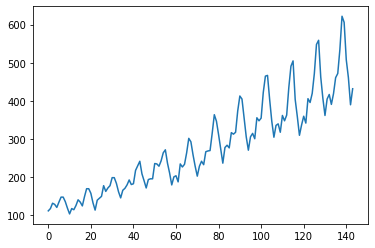

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

## Prepare the training and testing dataset.


In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Create the model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        # Your code goes here
        # define a lstm block and a fc block
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
       
        # Your code goes here
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

## Training

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):

    # Your code goes here
    # define a training iteration to the lstm model. Use loss variable to compute the training loss
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.06601
Epoch: 100, loss: 0.00327
Epoch: 200, loss: 0.00249
Epoch: 300, loss: 0.00200
Epoch: 400, loss: 0.00180
Epoch: 500, loss: 0.00172
Epoch: 600, loss: 0.00170
Epoch: 700, loss: 0.00168
Epoch: 800, loss: 0.00168
Epoch: 900, loss: 0.00167
Epoch: 1000, loss: 0.00167
Epoch: 1100, loss: 0.00167
Epoch: 1200, loss: 0.00166
Epoch: 1300, loss: 0.00166
Epoch: 1400, loss: 0.00166
Epoch: 1500, loss: 0.00166
Epoch: 1600, loss: 0.00166
Epoch: 1700, loss: 0.00165
Epoch: 1800, loss: 0.00164
Epoch: 1900, loss: 0.00164


## Test and Visualize the results. 
Plot the output of time series similar to the data plot above.

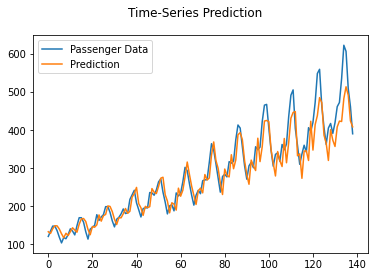

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_pred = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_pred = sc.inverse_transform(data_pred)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.plot(dataY_plot,label='Passenger Data')
plt.plot(data_pred,label='Prediction')
plt.suptitle('Time-Series Prediction')
plt.legend();

#### **Welcome to Assignment 4 (part-2) on Deep Learning for Computer Vision.**
This question consists of two subsection. In subsection-1 you'll have to code a Siamese Network, for subsection-2 you need to go through a official PyTorch tutorial on Object Detection, understand it and answer some questions.
  
#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import BatchSampler
from torch.optim import lr_scheduler
from PIL import Image
import timeit

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)
########################

#### YOUR CODE STARTS HERE ####
# Check availability of GPU and set the device accordingly
if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"
device = torch.device(dev)
#### YOUR CODE ENDS HERE ####


#### Prepare the dataset for Siamese Network

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, train=True):
        
        self.train = train
        #### YOUR CODE STARTS HERE ####
        # Define a set of transforms for preparing the dataset
        self.transform =  transforms.Compose([
                          # convert the image to a pytorch tensor
                          transforms.ToTensor(),
                          # normalise the images with mean and std of the dataset
                          transforms.Normalize((0.1307), (0.3081)),
        ])
        # Load the MNIST training, test datasets using `torchvision.datasets.MNIST
        # Set the train parameter to self.train and transform parameter to self.transform
        self.dataset =torchvision.datasets.MNIST(root='./data', train=self.train,download=True, transform=self.transform)

        #### YOUR CODE ENDS HERE ####
        if self.train:
            #### YOUR CODE STARTS HERE ####
            # assign input (x-values) of training data 
            self.train_data = self.dataset.train_data
            # assign labels of training data 
            self.train_labels = self.dataset.train_labels
            # get the set of all the labels in the dataset
            self.labels_all = set(self.train_labels.numpy())
            self.label_to_idx = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_all} # assign a unique index to all labels in the dataset and store them in a dictionary 

            #### YOUR CODE ENDS HERE ####
        else:
            #### YOUR CODE STARTS HERE ####
            # assign input (x-values) of test data 
            self.test_data = self.dataset.test_data
            # assign labels of test data 
            self.test_labels = self.dataset.test_labels
            # get the set of all the labels in the dataset
            self.labels_all = set(self.test_labels.numpy())
            self.label_to_idx = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_all} # assign a unique index to all labels in the dataset and store them in a dictionary 

            #### YOUR CODE ENDS HERE ####
            # DONOT change this line of code  
            random_state = np.random.RandomState(0)

            positive_samples = [] # this will be a list of lists
            for ind in range(0, len(self.test_data), 2):
              positive_samples.append([ind, random_state.choice(self.label_to_idx[self.test_labels[ind].item()]), 1])
            
            negative_samples = []
            for ind in range(1, len(self.test_data), 2):
              negative_samples.append([ind, random_state.choice(self.label_to_idx[np.random.choice(
                                                           list(self.labels_all - set([self.test_labels[ind].item()])))]), 0])
            
            # combine both positive and negative samples into a single variable
            #### YOUR CODE STARTS HERE ####
            self.test_samples = positive_samples + negative_samples
            #### YOUR CODE ENDS HERE ####
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # get image pair, and the associated label (1 for similar, 0 for dissimilar)
        if self.train:
            #### YOUR CODE STARTS HERE ####
            # choose if training sample is similar or dissimilar
            target = target = np.random.randint(0, 2)
            # choose two images call them `first_image` and `second_image`
            first_image=self.train_data[index]
            label1=self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_idx[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_all - set([label1])))
                siamese_index = np.random.choice(self.label_to_idx[siamese_label])
            second_image=self.train_data[siamese_index]
            #### YOUR CODE ENDS HERE ####
        else:
            #### YOUR CODE STARTS HERE ####
            # select two images from self.test_samples, call them `first_image` and `second_image`
            first_image = self.test_data[self.test_samples[index][0]]
            second_image = self.test_data[self.test_samples[index][1]]
            target = self.test_samples[index][2]
            #### YOUR CODE ENDS HERE ####
        
        first_image = Image.fromarray(first_image.numpy(), mode='L')
        second_image = Image.fromarray(second_image.numpy(), mode='L')
        first_image = self.transform(first_image)
        second_image = self.transform(second_image)
        return (first_image, second_image), target


In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # Define a sequential block as per the instructions below:
        # Build three blocks with each block containing: Conv->PReLU->Maxpool layers
        # Three conv layers should have 16, 32, 64 output channels respectively
        # Use convolution kernel size 3
        # For maxpool use a kernel size of 2 and stride of 2

        self.convnet = nn.Sequential(nn.Conv2d(1, 16, 3), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(16, 32, 3), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 3), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))


        # Define linear->PReLU->linear->PReLU->linear
        # The first two linear layers should have 256 and 128 output nodes
        # The final FC layer should have 2 nodes
        self.fc =nn.Sequential(nn.Linear(64, 256),
                                nn.PReLU(),
                                nn.Linear(256, 128),
                                nn.PReLU(),
                                nn.Linear(128, 2)
                                )

        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
      #### YOUR CODE STARTS HERE ####
        # Define the forward pass, convnet -> fc
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = torch.flatten(output,1)
        output = self.fc(output)
        #### YOUR CODE ENDS HERE ####
        return output

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        # Call the embedding network for both the inputs and return the output
        #### YOUR CODE ENDS HERE ####
        op1 = self.embedding_net(x1)
        op2 = self.embedding_net(x2)
        #### YOUR CODE ENDS HERE ####
        return op1, op2

Pairwise contrastive loss
$$
L\left(x_{0}, x_{1}, y\right)=\frac{1}{2} y\left\|f\left(x_{0}\right)-f\left(x_{1}\right)\right\|_{2}^{2}+\frac{1}{2}(1-y)\left\{\max (0, m-\sqrt{\|f(x_{0})-f(x_{1})\|_{2}^{2} + \epsilon)})\right\}^{2}
$$

In [ ]:
class ContrastiveLossSiamese(nn.Module):

    def __init__(self, margin):
        super(ContrastiveLossSiamese, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target):
        # Use the equation mentioned above to define the loss
        #### YOUR CODE STARTS HERE ####
        dis = (output2 - output1).pow(2).sum(1)
        loss_value = 0.5 * (target.float() * dis +(1 + -1 * target).float() * F.relu(self.margin - (dis + self.eps).sqrt()).pow(2))
        #### YOUR CODE ENDS HERE ####
        loss_value = loss_value.mean()

        return loss_value

In [ ]:
def train(model, train_loader, device, optimizer, criterion, epoch):
    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        #data,target=data.to(device),target.to(device)
        # data is not a single value here,
        # ensure datatype of variable `data` is tuple
        data = tuple(d.cpu() for d in data)
        target = target.cpu()
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named outputs
        # python star operator will be useful here
        outputs = model(*data)
        # if the datatype of outputs is not a tuple, make it to a tuple
        if type(outputs) not in (tuple, list):
            outputs = (outputs)

        # create inputs to the contrastive loss (datatype should be tuple)
        loss_inp = outputs
        target = (target,)
        loss_inp += target
        # calculate the loss using criterion 
        loss_out = criterion(*loss_inp)
        loss = loss_out[0] if type(loss_out) in (tuple, list) else loss_out
        # append the loss to losses list and update the total_loss variable
        losses.append(loss.item())
        total_loss += loss.item()
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
        #### YOUR CODE ENDS HERE ####

        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses)))  
    total_loss /= (batch_idx + 1)
    print('Average loss on training set: {:.6f}'.format(total_loss))
    return total_loss

def test(model, test_loader, device, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
          target = target if len(target) > 0 else None
          #### YOUR CODE STARTS HERE ####
          # send the image, target to the device
          #data,target=data.to(device),target.to(device)
          # data is not a single value here,
          # ensure datatype of variable `data` is tuple
          data = tuple(d.cpu() for d in data)
          target = target.cpu()
          # pass the image to the model and assign the output to variable named outputs
          # python star operator will be useful here
          outputs = model(*data)
          # if the datatype of outputs is not a tuple, make it to a tuple
          if type(outputs) not in (tuple, list):
              outputs = (outputs)

          # create inputs to the contrastive loss
          loss_inp = outputs
          # datatype of target should be tuple
          target = (target,)
          loss_inp += target
          # calculate the loss
          loss_out = criterion(*loss_inp)
          loss = loss_out[0] if type(loss_out) in (tuple, list) else loss_out
          # update the test_loss variable
          test_loss += loss.item()
          #### YOUR CODE ENDS HERE ####

    test_loss /= len(test_loader)
    print('Average loss on test set: {:.6f}'.format(test_loss))
    return test_loss


In [ ]:
# define the training and test sets
# use SiameseDataset
train_dataset = SiameseDataset(True)
test_dataset = SiameseDataset(False)

# create dataloaders for training and test datasets
# use a batch size of 128 and set shuffle=True for the training set, set num_workers to 2 and pin_memory to True
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers=2, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = False, num_workers=2, pin_memory=True)

margin = 1.
# create a instance of the embedding network and pass it as input to Siamese network
embedding_net = EmbeddingNet()
model = SiameseNetwork(embedding_net)
# define the contrative loss with the specified margin
criterion = ContrastiveLossSiamese(margin)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision

Done!


In [ ]:
start = timeit.default_timer()
train_data=[]
test_data=[]
for epoch in range(1, 5):
  train_data.append(train(model, train_dataloader, device, optimizer, criterion, epoch))
  test_data.append(test(model, test_dataloader, device, criterion))

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.255644
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.188845
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.138287
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.117772
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.105398
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.096398
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.089778
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.084186
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.080262
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.077147
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.074554
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.072086
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.070238
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.068403
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.066718
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.065057
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.063564
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.062137
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.060919
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.059677
Train Epoc

### Question 4

Run the code cell above and plot(on the same graph) the average train and test losses w.r.t epochs trained.

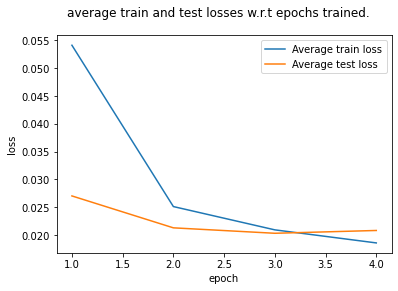

In [ ]:
import matplotlib.pyplot as plt

epochs=[i for i in range(1,5)]

plt.plot(epochs,train_data,label='Average train loss')
plt.plot(epochs,test_data,label='Average test loss')
plt.suptitle('average train and test losses w.r.t epochs trained.')
plt.xlabel('epoch') 
plt.ylabel('loss') 
plt.legend();

### Question 5

We have looked at training a Siamese Network with a pairwise contrastive loss. How would you modify the architecture above to use a triplet loss? The triplet loss is a ranking loss that uses image triplets consisting of an anchor $x_a$, a positive sample(similar to the anchor image) $x_p$ and a negative sample(dissimilar to the anchor image) $x_n$. Given triplet $(x_a, x_p, x_n)$ the teiplet loss is:

$$
L\left(x_{a}, x_{p}, x_{n}\right)=\max \left(0, m + \|f(x_{a})-f(x_{p})\|_{2}^{2} - \|f(x_{a})-f(x_{n})\|_{2}^{2}\right)
$$

1. Write the dataloader to get triplets.
2. Write code for class TripletLossSiamese. (the triplet loss)
3. Describe in words how would you modify the network architecture to train it with a triplet loss.

In [ ]:
# Question 2.1, dataloader for triplets
class TripletDataset(Dataset):
    def __init__(self, train=True):
        
        self.train = train
        #### YOUR CODE STARTS HERE ####
        self.transform =  transforms.Compose([
                          # convert the image to a pytorch tensor
                          transforms.ToTensor(),
                          # normalise the images with mean and std of the dataset
                          transforms.Normalize((0.1307), (0.3081)),
        ])
        # Load the MNIST training, test datasets using `torchvision.datasets.MNIST
        # Set the train parameter to self.train and transform parameter to self.transform
        self.dataset =torchvision.datasets.MNIST(root='./data', train=self.train,download=True, transform=self.transform)

        #### YOUR CODE ENDS HERE ####
        if self.train:
            #### YOUR CODE STARTS HERE ####
            # assign input (x-values) of training data 
            self.train_data = self.dataset.train_data
            # assign labels of training data 
            self.train_labels = self.dataset.train_labels
            # get the set of all the labels in the dataset
            self.labels_all = set(self.train_labels.numpy())
            self.label_to_idx = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_all} # assign a unique index to all labels in the dataset and store them in a dictionary 

            #### YOUR CODE ENDS HERE ####
        else:
            #### YOUR CODE STARTS HERE ####
            # assign input (x-values) of test data 
            self.test_data = self.dataset.test_data
            # assign labels of test data 
            self.test_labels = self.dataset.test_labels
            # get the set of all the labels in the dataset
            self.labels_all = set(self.test_labels.numpy())
            self.label_to_idx = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_all} # assign a unique index to all labels in the dataset and store them in a dictionary 


            #### YOUR CODE ENDS HERE ####
            # DONOT change this line of code  
            random_state = np.random.RandomState(0)
            triplets = [] #this will be list of lists
            for i in range(len(self.test_data)):
                triplets.append([i, random_state.choice(self.label_to_idx[self.test_labels[i].item()]),
                 random_state.choice(self.label_to_idx[np.random.choice(list(self.labels_all - set([self.test_labels[i].item()])))])
                                ])
            self.test_samples = triplets

           
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # get image triplet
        if self.train:
            anchor, anchor_label = self.train_data[index], self.train_labels[index].item
            #### YOUR CODE STARTS HERE ####
            #choose positive and negative image call them `positive` and `negative` respectively
            positive_idx = index
            while positive_idx == index:
                positive_idx = np.random.choice(self.label_to_idx[anchor_label])
            negative_label = np.random.choice(list(self.labels_all - set([anchor_label])))
            negative_idx = np.random.choice(self.label_to_indices[negative_label])
            positive = self.train_data[positive_idx]
            negative = self.train_data[negative_idx]
            #### YOUR CODE ENDS HERE ####
        else:
            #### YOUR CODE STARTS HERE ####
            # select three images from self.test_samples
            anchor = self.test_data[self.test_samples[index][0]]
            positive = self.test_data[self.test_samples[index][1]]
            negative = self.test_data[self.test_samples[index][2]]
            #### YOUR CODE ENDS HERE ####
        
        anchor = Image.fromarray(anchor.numpy(), mode='L')
        positive = Image.fromarray(positive.numpy(), mode='L')
        negative = Image.fromarray(negative.numpy(), mode='L')
        anchor = self.transform(anchor)
        positive = self.transform(positive)
        negative = self.transform(negative)
        return (anchor, positive, negative), []

In [ ]:
# Question 2.2, define triplet loss
class TripletLossSiamese(nn.Module):

    def __init__(self, margin):
        super(TripletLossSiamese, self).__init__()
        self.margin = margin

    def forward(self, output_anchor, output_positive, output_negative):
        # Use the triplet loss equation mentioned above to define the loss
        #### YOUR CODE STARTS HERE ####
        distance_pos = (anchor - positive).pow(2).sum(1)
        distance_neg = (anchor - negative).pow(2).sum(1)
        losses = F.relu(distance_pos - distance_neg + self.margin)
        #### YOUR CODE ENDS HERE ####
        loss_value = loss_value.mean()

        return loss_value

To train the network with triplet loss, we create triplets of data from an existing data set and then minimize the loss on it.

## Object Detection

Go through the [Torchvision Object Detection Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) and ensure you understand the tutorial completely!

After you have completely gone through the tutorial answer the following questions!

### Question 6

Consider the metrics `AP@IoU=0.5` and `AP@IoU=0.75` used in the tutorial. Which of the following statements is True?  

1. `IoU@0.75` will always be less than `IoU@0.5`
2. `IoU@0.75` will always be  greater than `IoU@0.5` 
3. `IoU@0.75` need not be always be less than `IoU@0.5`
4. `IoU@0.75` need not always be  greater than `IoU@0.5` 

The answer is option 1. As we can see from the toutrial IOU@0.5 is always greater than IOU@0.75

### Question 7

Tutorial uses a network that is pre-trained on COCO dataset. Will training this model from scratch improve the performance? Provide justification for your answer. (Hint: You don't really have to re-train the model for this)

No training the model from scratch wont improve the performance.
As the dataset is small training it from start will overfit the model.

### Question 8

Write code to calculate IoU between aligned predicted bounding-boxes bbox_p and ground-truth bounding-boxes bbox_gt. Assume a co-ordinate system that has origin (0,0) at the upper-left corner of the image, and to the  right and down are +ve directions of x-axis and y-axis respectively.

In [ ]:
def calculate_iou(bbox_p, bbox_gt):
    #input: bbox_p and bbox_gt are (N,4) tensors
    #output: ious (N,) vector
    N = bbox_p.size(0)
    
    #### YOUR CODE STARTS HERE ####
    # write code to compute the IoU between the bounding boxes
    # Let (x,y) be the position at bottom right corner
    x_left = max(bbox_p[0], bbox_gt[0])
    y_top = max(bbox_p[0], bbox_gt[0])
    x_right = min(bbox_p['x'], bbox_gt['x'])
    y_bottom = min(bbox_p['y'], bbox_gt['y'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left +1) * (y_bottom - y_top +1)
    bbox_p_area = (bbox_p['x'] - bbox_p['0']) * (bbox_p['y'] - bbox_p['0'])
    bbox_gt_area = (bbox_gt['x'] - bbox_gt['0']) * (bbox_gt['y'] - bbox_gt['0'])

    ious = intersection_area / float(bbox_p_area + bbox_gt_area - intersection_area)
    #### YOUR CODE ENDS HERE ####
    
    return ious